### Test notebook for OD experiments


In [1]:
# Perform imports
from collections import OrderedDict
import torch
import numpy as np
from torchvision.models import detection
from torch import nn
from torchvision.datasets import CocoDetection
from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm
import signal
from datetime import datetime
from torch.utils.data import DataLoader, Dataset, Sampler
import os
from src.evaluators.pascal_voc_evaluator import get_pascalvoc_metrics
from src.utils.enumerators import MethodAveragePrecision
from src.bounding_box import BoundingBox, BBType, BBFormat
from itertools import chain
import json
import pandas as pd
from IPython.display import display
import faiss
from sklearn.manifold import TSNE
import fiftyone as fo
import fiftyone.utils.coco as fouc
from PIL import Image

# Global config
%load_ext line_profiler

plt.rcParams['figure.figsize'] = (20, 10)


In [2]:
# determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

COCO_LABELS = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'street sign',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'hat',
    'backpack',
    'umbrella',
    'shoe',
    'eye glasses',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'plate',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'mirror',
    'dining table',
    'window',
    'desk',
    'toilet',
    'door',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'blender',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush',
    'hair brush',
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_LABELS), 3))

LABEL_DICT = {
    'car': 'vehicle',
    'bus': 'vehicle',
    'truck': 'vehicle',
    'caravan': 'vehicle',
    'trailer': 'vehicle',
    'motorcycle': 'vehicle',
    'train': 'vehicle',
    'bicycle': 'vehicle',
    'person': 'pedestrian',
    'rider': 'pedestrian',
}

# Use pretrained model frcnn-mobilenet
model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True,
                                                        num_classes=len(COCO_LABELS), pretrained_backbone=True).to(DEVICE)

Running on cuda


### Test model with a single image


In [5]:
def preprocess(image):
    image = image.transpose((2, 0, 1))

    # Reformat image data
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    image = torch.FloatTensor(image)
    image = torch.squeeze(image, 0)

    # Move data to correct device
    return image.to(DEVICE, non_blocking=True)


def draw_detections(image, detections, tol):
    # Loop over detections
    for i in range(0, len(detections["boxes"])):
        score = detections["scores"][i]

        # Ignore any detections below the tolerance
        if score > tol:
            # Pull important data
            idx = int(detections["labels"][i])
            cat = get_cat(idx)
            box = detections["boxes"][i].detach().cpu().numpy()
            (x0, y0, x1, y1) = box.astype("int")
            label = "{}: {:.2f}%".format(cat['name'], score * 100)

            # draw the bounding box and label on the image
            cv2.rectangle(image, (x0, y0), (x1, y1),
                          COLORS[idx], 2)
            y = y0 - 15 if y0 - 15 > 15 else y0 + 15
            cv2.putText(image, label, (x0, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    return image


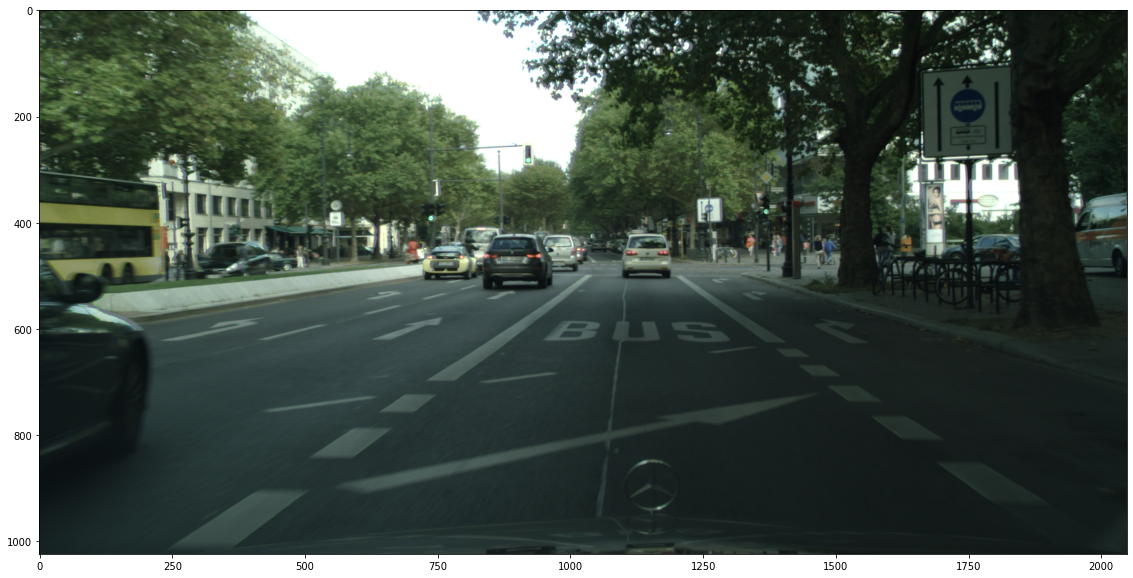

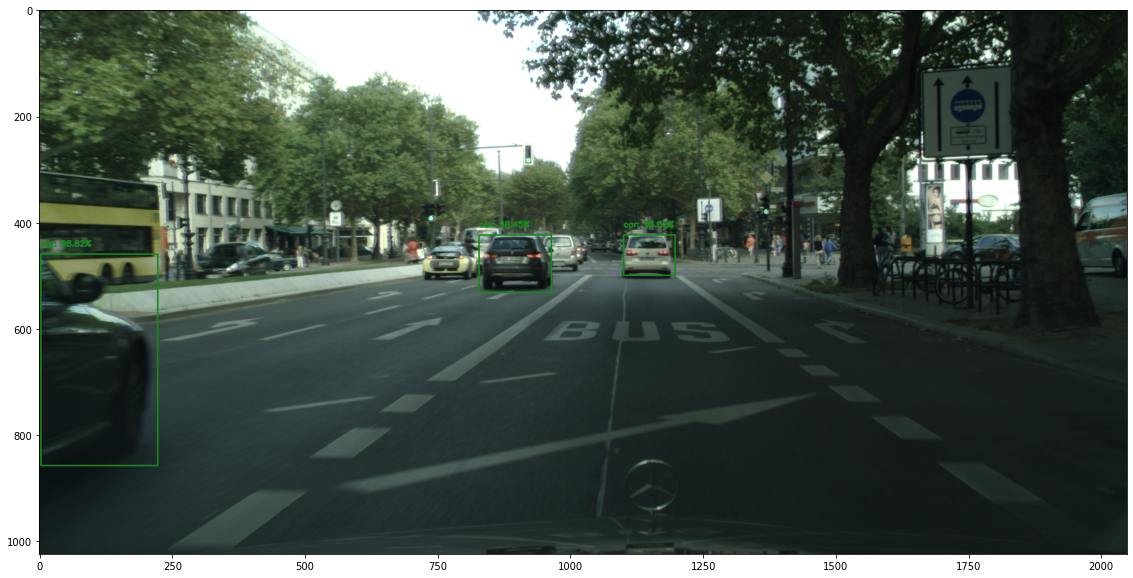

In [109]:
# Load test image
image = cv2.imread(
    "data/datasets/Cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orig = image.copy()

plt.imshow(image)
plt.show()


image = preprocess(image)
result = model([image])

detections = result[0]

box_image = draw_detections(orig, detections, 0.8)

plt.imshow(box_image)
plt.show()


### Run on video


In [5]:
# Prepare video
class VideoDataset(Dataset):

    def __init__(self, vid_path):
        self.vid_path = vid_path
        self.cap = cv2.VideoCapture(vid_path)

    def __len__(self):
        return int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __getitem__(self, idx):
        frame = self.get_frame(idx)
        orig = frame.copy()
        data = preprocess(frame)

        return orig, data

    def get_frame(self, idx):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = self.cap.read()

        return frame


In [110]:
# Get reference to video
def video():
    model.eval()
    # batch_size = 8
    # video_dataset = VideoDataset('data/highway_video.mp4')

    # video_dataloader = DataLoader(
    #     video_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

    cap = cv2.VideoCapture('data/highway_video.mp4')
    # cap = video_dataset.cap
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get video format
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer
    vwriter = cv2.VideoWriter()
    vwriter.open(
        f'data/outputs/highway_video_out_{datetime.now().isoformat()}.mp4', fourcc, fps, (w, h), True)

    def signal_handler(sig, _):
        print('SIGINT recieved')
        global sig_int
        sig_int = True

    signal.signal(signal.SIGINT, signal_handler)

    # Loop through video
    global sig_int
    sig_int = False
    ret = True
    with tqdm(total=num_frames+1) as pbar:
        while(ret):
            # Get frame and pre process
            ret, frame = cap.read()
            img = frame.copy()

            if ret == False:
                break

            img = np.array(img)
            img = img.transpose((2, 0, 1))
            img = img / 255.0
            img = torch.FloatTensor(img)
            img = img.to(DEVICE)

            results = model([img])

            for i, detections in enumerate(results):
                out = draw_detections(frame, detections, 0.5)
                vwriter.write(out)

            if sig_int:
                break

            pbar.update(1)

    # Release both input and output videos
    cap.release()
    vwriter.release()


# %lprun -T video_prof.txt -f video video()
video()


  0%|          | 0/9185 [00:00<?, ?it/s]

SIGINT recieved


### Cityscapes Finetuning


In [3]:
CITYSCAPES_ROOT = 'data/datasets/Cityscapes'
train = CocoDetection(os.path.join(CITYSCAPES_ROOT), os.path.join(
    CITYSCAPES_ROOT, 'annotations/instancesonly_filtered_gtFine_train.json'))

CITYSCAPES_ROOT = 'data/datasets/Cityscapes'
val = CocoDetection(os.path.join(CITYSCAPES_ROOT), os.path.join(
    CITYSCAPES_ROOT, 'annotations/instancesonly_filtered_gtFine_val.json'))

COCO_cats = [{"supercategory": "person", "id": 1, "name": "person"}, {"supercategory": "vehicle", "id": 2, "name": "bicycle"}, {"supercategory": "vehicle", "id": 3, "name": "car"}, {"supercategory": "vehicle", "id": 4, "name": "motorcycle"}, {"supercategory": "vehicle", "id": 5, "name": "airplane"}, {"supercategory": "vehicle", "id": 6, "name": "bus"}, {"supercategory": "vehicle", "id": 7, "name": "train"}, {"supercategory": "vehicle", "id": 8, "name": "truck"}, {"supercategory": "vehicle", "id": 9, "name": "boat"}, {"supercategory": "outdoor", "id": 10, "name": "traffic light"}, {"supercategory": "outdoor", "id": 11, "name": "fire hydrant"}, {"supercategory": "outdoor", "id": 13, "name": "stop sign"}, {"supercategory": "outdoor", "id": 14, "name": "parking meter"}, {"supercategory": "outdoor", "id": 15, "name": "bench"}, {"supercategory": "animal", "id": 16, "name": "bird"}, {"supercategory": "animal", "id": 17, "name": "cat"}, {"supercategory": "animal", "id": 18, "name": "dog"}, {"supercategory": "animal", "id": 19, "name": "horse"}, {"supercategory": "animal", "id": 20, "name": "sheep"}, {"supercategory": "animal", "id": 21, "name": "cow"}, {"supercategory": "animal", "id": 22, "name": "elephant"}, {"supercategory": "animal", "id": 23, "name": "bear"}, {"supercategory": "animal", "id": 24, "name": "zebra"}, {"supercategory": "animal", "id": 25, "name": "giraffe"}, {"supercategory": "accessory", "id": 27, "name": "backpack"}, {"supercategory": "accessory", "id": 28, "name": "umbrella"}, {"supercategory": "accessory", "id": 31, "name": "handbag"}, {"supercategory": "accessory", "id": 32, "name": "tie"}, {"supercategory": "accessory", "id": 33, "name": "suitcase"}, {"supercategory": "sports", "id": 34, "name": "frisbee"}, {"supercategory": "sports", "id": 35, "name": "skis"}, {"supercategory": "sports", "id": 36, "name": "snowboard"}, {"supercategory": "sports", "id": 37, "name": "sports ball"}, {"supercategory": "sports", "id": 38, "name": "kite"}, {"supercategory": "sports", "id": 39, "name": "baseball bat"}, {"supercategory": "sports", "id": 40, "name": "baseball glove"}, {"supercategory": "sports", "id": 41, "name": "skateboard"}, {"supercategory": "sports", "id": 42, "name": "surfboard"}, {"supercategory": "sports", "id": 43, "name": "tennis racket"}, {"supercategory": "kitchen", "id": 44, "name": "bottle"}, {
    "supercategory": "kitchen", "id": 46, "name": "wine glass"}, {"supercategory": "kitchen", "id": 47, "name": "cup"}, {"supercategory": "kitchen", "id": 48, "name": "fork"}, {"supercategory": "kitchen", "id": 49, "name": "knife"}, {"supercategory": "kitchen", "id": 50, "name": "spoon"}, {"supercategory": "kitchen", "id": 51, "name": "bowl"}, {"supercategory": "food", "id": 52, "name": "banana"}, {"supercategory": "food", "id": 53, "name": "apple"}, {"supercategory": "food", "id": 54, "name": "sandwich"}, {"supercategory": "food", "id": 55, "name": "orange"}, {"supercategory": "food", "id": 56, "name": "broccoli"}, {"supercategory": "food", "id": 57, "name": "carrot"}, {"supercategory": "food", "id": 58, "name": "hot dog"}, {"supercategory": "food", "id": 59, "name": "pizza"}, {"supercategory": "food", "id": 60, "name": "donut"}, {"supercategory": "food", "id": 61, "name": "cake"}, {"supercategory": "furniture", "id": 62, "name": "chair"}, {"supercategory": "furniture", "id": 63, "name": "couch"}, {"supercategory": "furniture", "id": 64, "name": "potted plant"}, {"supercategory": "furniture", "id": 65, "name": "bed"}, {"supercategory": "furniture", "id": 67, "name": "dining table"}, {"supercategory": "furniture", "id": 70, "name": "toilet"}, {"supercategory": "electronic", "id": 72, "name": "tv"}, {"supercategory": "electronic", "id": 73, "name": "laptop"}, {"supercategory": "electronic", "id": 74, "name": "mouse"}, {"supercategory": "electronic", "id": 75, "name": "remote"}, {"supercategory": "electronic", "id": 76, "name": "keyboard"}, {"supercategory": "electronic", "id": 77, "name": "cell phone"}, {"supercategory": "appliance", "id": 78, "name": "microwave"}, {"supercategory": "appliance", "id": 79, "name": "oven"}, {"supercategory": "appliance", "id": 80, "name": "toaster"}, {"supercategory": "appliance", "id": 81, "name": "sink"}, {"supercategory": "appliance", "id": 82, "name": "refrigerator"}, {"supercategory": "indoor", "id": 84, "name": "book"}, {"supercategory": "indoor", "id": 85, "name": "clock"}, {"supercategory": "indoor", "id": 86, "name": "vase"}, {"supercategory": "indoor", "id": 87, "name": "scissors"}, {"supercategory": "indoor", "id": 88, "name": "teddy bear"}, {"supercategory": "indoor", "id": 89, "name": "hair drier"}, {"supercategory": "indoor", "id": 90, "name": "toothbrush"}]


def get_cat(id):
    return next(item for item in COCO_cats if item["id"] == id)


def find_cat_by_name(name):
    if (name in COCO_LABELS):
        return next(item for item in COCO_cats if item["name"] == name)
    else:
        return None


def ann_to_target(ann, cats):
    num_objs = len(ann)

    if num_objs == 0:
        return {}

    boxes = []
    for i in range(num_objs):
        xmin = ann[i]['bbox'][0]
        ymin = ann[i]['bbox'][1]
        xmax = xmin + ann[i]['bbox'][2]
        ymax = ymin + ann[i]['bbox'][3]
        boxes.append([xmin, ymin, xmax, ymax])
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    labels = []
    for i in range(num_objs):
        cat_id = ann[i]['category_id']
        if cat_id != 0:
            cat = cats[cat_id]
            cat_name = cat['name']

            # Relabel rider as person
            if cat_name == 'rider':
                cat_name = 'person'

            new_cat = find_cat_by_name(cat_name)
            cat_id = new_cat['id']

            if new_cat['name'] != cat_name:
                print('Mismatch!')

        labels.append(cat_id)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    img_id = torch.tensor(ann[0]['image_id'])

    areas = []
    for i in range(num_objs):
        areas.append(ann[i]['area'])
    areas = torch.as_tensor(areas, dtype=torch.float32)

    iscrowd = []
    for i in range(num_objs):
        iscrowd.append(ann[i]['iscrowd'])
    iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

    # Annotation is in dictionary format
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = img_id
    target["area"] = areas
    target["iscrowd"] = iscrowd

    return target


def collate_fn(batch, cats):
    images = []
    targets = []
    for data in batch:
        img, ann = data

        img = np.array(img)
        img = img.transpose((2, 0, 1))
        img = img / 255.0
        img = torch.FloatTensor(img)
        img = img.to(DEVICE)

        target = ann_to_target(ann, cats)

        # if target == None:
        #     continue

        images.append(img)
        targets.append(target)

    return (images, targets)


def train_collate_fn(batch):
    return collate_fn(batch, train.coco.cats)


def val_collate_fn(batch):
    return collate_fn(batch, val.coco.cats)


BATCH_SIZE = 4

train_dataloader = DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_collate_fn)

val_dataloader = DataLoader(
    val, batch_size=BATCH_SIZE, shuffle=True, collate_fn=val_collate_fn)


loading annotations into memory...
Done (t=7.93s)
creating index...
index created!
loading annotations into memory...
Done (t=1.22s)
creating index...
index created!


In [4]:
def train_model(model: nn.Module, loader: DataLoader, verbose=False):
    model.train()

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    with tqdm(total=len(loader)) as pbar:
        for i, batch in enumerate(loader):
            imgs, targets = batch

            if len(targets) != 0:
                loss_dict = model(imgs, targets)

                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                if verbose == True:
                    print(f'Iteration: {i}, Loss: {losses}')

            pbar.update(1)

    return model


In [5]:
def from_dict_to_boundingbox(file: dict, image_id: int, groundtruth: bool = True):
    """Returns list of BoundingBox objects from groundtruth or prediction."""
    labels = file["labels"]
    boxes = file["boxes"]
    scores = np.array(file["scores"]
                      ) if not groundtruth else [None] * len(boxes)

    gt = BBType.GROUND_TRUTH if groundtruth else BBType.DETECTED

    return [
        BoundingBox(
            image_name=image_id,
            class_id=int(label),
            coordinates=tuple(np.round(box)),
            format=BBFormat.XYX2Y2,
            bb_type=gt,
            confidence=score,
        )
        for box, label, score in zip(boxes, labels, scores)
    ]


class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()

        if isinstance(obj, MethodAveragePrecision):
            return 'EVERY_POINT_INTERPOLATION'

        if isinstance(obj, pd.DataFrame):
            return obj.to_json()
        return json.JSONEncoder.default(self, obj)


def preds_to_boundingbox(preds, image_ids, gt=False):
    return [(image_id, from_dict_to_boundingbox(pred, image_id=image_id, groundtruth=gt)) for pred, image_id in zip(preds, image_ids)]


def eval_preds(targets, preds, image_ids, per_image_mAP=False):
    gt_boxes = preds_to_boundingbox(targets, image_ids, gt=True)
    pred_boxes = preds_to_boundingbox(preds, image_ids, gt=False)

    if per_image_mAP == True:
        mAPs = [(image_id, calc_mAP(gt_box[1], pred_box[1])) for gt_box,
                pred_box, image_id in zip(gt_boxes, pred_boxes, image_ids)]
    else:
        mAPs = None

    return gt_boxes, pred_boxes, mAPs

def detach_targets(targets):
    for target in targets:
        for key in target.keys():

            if type(target[key]) == torch.Tensor:
                target[key] = target[key].cpu().detach().numpy()

    return targets

def predict(model, imgs, targets, per_image_mAP=False):
    # Pre filter targets as some do not contain detections TODO: Put blank targets when they dont exist?
    preds = model(imgs)

    targets = detach_targets(targets)
    preds = detach_targets(preds)

    image_ids = [target['image_id'] for target in targets]
    gt_boxes, pred_boxes, mAPs = eval_preds(
        targets, preds, image_ids, per_image_mAP)

    return image_ids, preds, gt_boxes, pred_boxes, mAPs


def calc_mAP(gt_boxes, pred_boxes):
    if (len(gt_boxes) == 0):
        mAP = 0  # TODO: Should this be 1 or 0 or nothing?
    else:
        mAP = get_pascalvoc_metrics(gt_boxes=gt_boxes,
                                    det_boxes=pred_boxes,
                                    iou_threshold=0.5,
                                    method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                                    generate_table=False)['mAP']
    return mAP


def eval_model(model: nn.Module, loader: DataLoader, per_image_mAP=False):
    model.eval()

    features = []

    def get_features():
        def hook(model, inputs, outputs):
            features.extend(outputs.cpu().detach())

        return hook

    model.backbone.body['16']._forward_hooks = OrderedDict()
    model.backbone.body['16'].register_forward_hook(get_features())

    all_ids = []
    all_gt_boxes = []
    all_pred_boxes = []
    all_mAPs = []

    with tqdm(total=len(loader)) as pbar:
        for batch in loader:
            imgs, targets = batch

            image_ids, preds, gt_boxes, pred_boxes, mAPs = predict(
                model, imgs, targets, per_image_mAP)

            all_ids.extend(image_ids)
            all_gt_boxes.extend(gt_boxes)
            all_pred_boxes.extend(pred_boxes)
            if mAPs != None:
                all_mAPs.extend(mAPs)

            pbar.update(1)

    metrics = get_pascalvoc_metrics(gt_boxes=list(chain(*[boxes[1] for boxes in all_gt_boxes])),
                                    det_boxes=list(
                                        chain(*[boxes[1] for boxes in all_pred_boxes])),
                                    iou_threshold=0.5,
                                    method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION,
                                    generate_table=True)

    return all_ids, preds, metrics, all_gt_boxes, all_pred_boxes, features, all_mAPs

In [23]:
for obj_class in per_class:
    print(COCO_cats[obj_class]['name'])
    display(per_class[obj_class]['table'])


bicycle


image confidence  TP  FP  acc TP  acc FP  precision    recall
0      3107     99.97%   1   0     1.0     0.0   1.000000  0.000263
1      3007     99.95%   1   0     2.0     0.0   1.000000  0.000526
2      3347     99.94%   1   0     3.0     0.0   1.000000  0.000790
3      3211     99.94%   1   0     4.0     0.0   1.000000  0.001053
4      3415     99.94%   1   0     5.0     0.0   1.000000  0.001316
...     ...        ...  ..  ..     ...     ...        ...       ...
4799   3099      5.01%   0   1  1005.0  3795.0   0.209375  0.264543
4800   3259      5.01%   0   1  1005.0  3796.0   0.209331  0.264543
4801   3415      5.01%   0   1  1005.0  3797.0   0.209288  0.264543
4802   3163      5.01%   0   1  1005.0  3798.0   0.209244  0.264543
4803   3395      5.01%   0   1  1005.0  3799.0   0.209201  0.264543

[4804 rows x 8 columns]

motorcycle


image confidence  TP  FP  acc TP  acc FP  precision    recall
0      3047     99.86%   1   0     1.0     0.0   1.000000  0.000221
1      3035     99.86%   1   0     2.0     0.0   1.000000  0.000442
2      3347     99.83%   1   0     3.0     0.0   1.000000  0.000663
3      3199     99.82%   1   0     4.0     0.0   1.000000  0.000884
4      3395     99.80%   1   0     5.0     0.0   1.000000  0.001105
...     ...        ...  ..  ..     ...     ...        ...       ...
5576   3051      5.01%   0   1  1780.0  3797.0   0.319168  0.393457
5577   3463      5.01%   0   1  1780.0  3798.0   0.319111  0.393457
5578   3219      5.01%   0   1  1780.0  3799.0   0.319054  0.393457
5579   3283      5.00%   0   1  1780.0  3800.0   0.318996  0.393457
5580   3023      5.00%   0   1  1780.0  3801.0   0.318939  0.393457

[5581 rows x 8 columns]

train


image confidence  TP  FP  acc TP  acc FP  precision    recall
0     3031     99.95%   1   0     1.0     0.0   1.000000  0.010309
1     3131     99.94%   1   0     2.0     0.0   1.000000  0.020619
2     3279     99.90%   1   0     3.0     0.0   1.000000  0.030928
3     3079     99.83%   1   0     4.0     0.0   1.000000  0.041237
4     3251     99.79%   1   0     5.0     0.0   1.000000  0.051546
..     ...        ...  ..  ..     ...     ...        ...       ...
247   3131      5.14%   0   1    44.0   204.0   0.177419  0.453608
248   3043      5.10%   0   1    44.0   205.0   0.176707  0.453608
249   3335      5.06%   0   1    44.0   206.0   0.176000  0.453608
250   3087      5.05%   0   1    44.0   207.0   0.175299  0.453608
251   3443      5.03%   0   1    44.0   208.0   0.174603  0.453608

[252 rows x 8 columns]

car


image confidence  TP  FP  acc TP  acc FP  precision    recall
0     3091     99.76%   1   0     1.0     0.0   1.000000  0.000897
1     3091     99.73%   1   0     2.0     0.0   1.000000  0.001794
2     3395     99.62%   1   0     3.0     0.0   1.000000  0.002691
3     3239     99.55%   1   0     4.0     0.0   1.000000  0.003587
4     3299     99.51%   1   0     5.0     0.0   1.000000  0.004484
..     ...        ...  ..  ..     ...     ...        ...       ...
949   3099      5.02%   0   1   220.0   730.0   0.231579  0.197309
950   2999      5.01%   1   0   221.0   730.0   0.232387  0.198206
951   3075      5.01%   0   1   221.0   731.0   0.232143  0.198206
952   3363      5.01%   0   1   221.0   732.0   0.231899  0.198206
953   3083      5.01%   0   1   221.0   733.0   0.231656  0.198206

[954 rows x 8 columns]

boat


image confidence  TP  FP  acc TP  acc FP  precision    recall
0      3251     99.82%   1   0     1.0     0.0   1.000000  0.010870
1      3299     99.78%   1   0     2.0     0.0   1.000000  0.021739
2      3303     99.53%   1   0     3.0     0.0   1.000000  0.032609
3      3007     98.26%   0   1     3.0     1.0   0.750000  0.032609
4      3203     97.89%   1   0     4.0     1.0   0.800000  0.043478
...     ...        ...  ..  ..     ...     ...        ...       ...
1173   3059      5.04%   0   1    35.0  1139.0   0.029813  0.380435
1174   3063      5.04%   0   1    35.0  1140.0   0.029787  0.380435
1175   3007      5.04%   0   1    35.0  1141.0   0.029762  0.380435
1176   2975      5.04%   0   1    35.0  1142.0   0.029737  0.380435
1177   3147      5.02%   0   1    35.0  1143.0   0.029711  0.380435

[1178 rows x 8 columns]

airplane


image confidence  TP  FP  acc TP  acc FP  precision    recall
0     3395     98.77%   1   0     1.0     0.0   1.000000  0.006993
1     3243     96.84%   1   0     2.0     0.0   1.000000  0.013986
2     3411     96.82%   1   0     3.0     0.0   1.000000  0.020979
3     2999     93.24%   1   0     4.0     0.0   1.000000  0.027972
4     3243     93.16%   1   0     5.0     0.0   1.000000  0.034965
..     ...        ...  ..  ..     ...     ...        ...       ...
412   3011      5.05%   0   1    29.0   384.0   0.070218  0.202797
413   3071      5.04%   0   1    29.0   385.0   0.070048  0.202797
414   3223      5.03%   0   1    29.0   386.0   0.069880  0.202797
415   3411      5.01%   0   1    29.0   387.0   0.069712  0.202797
416   3083      5.01%   0   1    29.0   388.0   0.069544  0.202797

[417 rows x 8 columns]

truck


image confidence  TP  FP  acc TP  acc FP  precision    recall
0    3455     72.76%   1   0     1.0     0.0   1.000000  0.045455
1    3427     46.34%   0   1     1.0     1.0   0.500000  0.045455
2    3323     31.61%   1   0     2.0     1.0   0.666667  0.090909
3    3427     26.25%   0   1     2.0     2.0   0.500000  0.090909
4    3243     21.95%   0   1     2.0     3.0   0.400000  0.090909
5    3367     17.99%   0   1     2.0     4.0   0.333333  0.090909
6    3363     16.40%   0   1     2.0     5.0   0.285714  0.090909
7    3335     16.15%   0   1     2.0     6.0   0.250000  0.090909
8    3391     12.05%   1   0     3.0     6.0   0.333333  0.136364
9    3331     11.63%   0   1     3.0     7.0   0.300000  0.136364
10   3427      6.87%   0   1     3.0     8.0   0.272727  0.136364
11   3147      6.01%   0   1     3.0     9.0   0.250000  0.136364
12   3323      5.53%   0   1     3.0    10.0   0.230769  0.136364
13   3335      5.34%   0   1     3.0    11.0   0.214286  0.136364

In [6]:
def show_bb(dataset, detections: list[list[BoundingBox]], index):
    image = dataset[index][0]
    image = np.array(image)

    confidences = []
    for detection in detections[index]:
        bb = detection.get_absolute_bounding_box(BBFormat.XYX2Y2)
        x1, y1, x2, y2 = tuple(int(pt) for pt in bb)
        p1 = (x1, y1)
        p2 = (x2, y2)
        class_id = detection.get_class_id()
        obj_class = get_cat(class_id)

        confidences.append(detection.get_confidence())

        image = cv2.rectangle(image, p1, p2, COLORS[obj_class['id']], 2)
        image = cv2.putText(image, obj_class['name'], (
            p1[0], p1[1] + 1), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))

    plt.imshow(image)
    plt.show()

    print(sum(confidences) / len(confidences))


show_bb(val, all_pred_boxes, 0)


NameError: name 'all_pred_boxes' is not defined

In [6]:
import random
import math


class AcquisitionSampler(Sampler):
    def __init__(self, pcnt):
        self.pcnt = pcnt

    def sample(self):
        class_name = self.__class__.__name__
        if class_name == AcquisitionSampler.__name__:
            raise NotImplementedError
        else:
            print(f'Sampling data with {class_name}')


class RandomAcquisition(AcquisitionSampler):
    def __init__(self, data_source, pcnt=0.2):
        super().__init__(pcnt)
        self.data_source = data_source

    def sample(self):
        super().sample()

        return random.sample(range(len(self.data_source)), len(self))

    def __iter__(self):
        sampled = self.sample()

        return iter(sampled)

    def __len__(self):
        return math.floor(len(self.data_source) * self.pcnt)


In [8]:
train_dataloader_rand = DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=False, sampler=RandomAcquisition(train), collate_fn=train_collate_fn
)

train_model(model, train_dataloader_rand)

metric = eval_model(model, val_dataloader)
per_class, mAP = metric['per_class'], metric['mAP']

print(mAP)


  0%|          | 0/149 [00:00<?, ?it/s]

Sampling data with RandomAcquisition


KeyboardInterrupt: 

### mAP for varying % dataset


In [244]:
MODEL_ROOT = './models'

def test_random_acquisition(run):
    print(f'Starting run {run}')
    inc = 0.1
    pcnts = np.around(np.arange(0.1, 1 + inc, inc), 1)

    results = []
    for pcnt in pcnts:
        print(f'Testing random {pcnt}')
        model_name = os.path.join(MODEL_ROOT, f'model_v2.0_rand_{pcnt}_{run}')
        if os.path.exists(model_name):
            print(f'Model already trained for {pcnt}, loading existing')
            model = torch.load(model_name)
        else:
            print(f'Training model for {pcnt}')
            loader = DataLoader(train, batch_size=BATCH_SIZE, sampler=RandomAcquisition(
                train, pcnt=pcnt), collate_fn=train_collate_fn)

            # Use pretrained model frcnn-mobilenet
            model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(
                pretrained=True,
                progress=True,
                num_classes=len(COCO_LABELS),
                pretrained_backbone=True
            ).to(DEVICE)

            model = train_model(model, loader)
            torch.save(model, model_name)

        print(f'Evaluating model for {pcnt}')
        evaluation = eval_model(model, val_dataloader)

        results.append([pcnt, evaluation])

    print(f'Completed run {run}')
    return results


def check_run(verbose=True):
    inc = 0.1
    pcnts = np.around(np.arange(0.1, 1 + inc, inc), 1)

    run = 0
    checking = True

    while checking:
        run_incomplete = False
        for pcnt in pcnts:
            model_name = os.path.join(
                MODEL_ROOT, f'model_v2.0_rand_{pcnt}_{run}')
            if os.path.exists(model_name):
                if verbose:
                    print(f'{model_name} exists')
            else:
                run_incomplete = True
                break

        if run_incomplete:
            if pcnt == 0.1:
                if verbose:
                    print(f'run {run} not started')
            else:
                if verbose:
                    print(f'run {run} partially completed')
            checking = False
        else:
            if verbose:
                print(f'run {run} already completed')
            run += 1

    return run


def save_run_results(run, results):
    print(f'Saving run {run} results')
    mAP = np.array([[result[0], result[1]['mAP']] for result in results])
    json_list = json.dumps(mAP.tolist())

    with open(f'mAP_rand_results_{run}.json', 'w') as outfile:
        outfile.write(json_list)

    return mAP


def plot_mAP(mAP, all_mAP=[]):
    plt.xlim((0, 1))
    plt.plot(mAP[:, 0], mAP[:, 1], 'k', linewidth=2, label='mAP')

    if np.any(all_mAP):
        for i in range(1, all_results.shape[1]):
            plt.plot(all_mAP[:, 0], all_mAP[:, i], ':', label=f'mAP run {i}')
            plt.legend()

    plt.xlabel('% sampled')
    plt.ylabel("mAP")
    plt.show()


./models/model_v2.0_rand_0.1_0 exists
./models/model_v2.0_rand_0.2_0 exists
./models/model_v2.0_rand_0.3_0 exists
./models/model_v2.0_rand_0.4_0 exists
./models/model_v2.0_rand_0.5_0 exists
./models/model_v2.0_rand_0.6_0 exists
./models/model_v2.0_rand_0.7_0 exists
./models/model_v2.0_rand_0.8_0 exists
./models/model_v2.0_rand_0.9_0 exists
./models/model_v2.0_rand_1.0_0 exists
run 0 already completed
./models/model_v2.0_rand_0.1_1 exists
./models/model_v2.0_rand_0.2_1 exists
./models/model_v2.0_rand_0.3_1 exists
./models/model_v2.0_rand_0.4_1 exists
./models/model_v2.0_rand_0.5_1 exists
./models/model_v2.0_rand_0.6_1 exists
./models/model_v2.0_rand_0.7_1 exists
./models/model_v2.0_rand_0.8_1 exists
./models/model_v2.0_rand_0.9_1 exists
./models/model_v2.0_rand_1.0_1 exists
run 1 already completed
./models/model_v2.0_rand_0.1_2 exists
./models/model_v2.0_rand_0.2_2 exists
./models/model_v2.0_rand_0.3_2 exists
./models/model_v2.0_rand_0.4_2 exists
./models/model_v2.0_rand_0.5_2 exists
./

  0%|          | 0/75 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.1


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.2
Training model for 0.2


  0%|          | 0/149 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.2


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.3
Training model for 0.3


  0%|          | 0/223 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.3


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.4
Training model for 0.4


  0%|          | 0/298 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.4


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.5
Training model for 0.5


  0%|          | 0/372 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.5


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.6
Training model for 0.6


  0%|          | 0/447 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.6


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.7
Training model for 0.7


  0%|          | 0/521 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.7


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.8
Training model for 0.8


  0%|          | 0/595 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.8


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 0.9
Training model for 0.9


  0%|          | 0/670 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.9


  0%|          | 0/125 [00:00<?, ?it/s]

Testing random 1.0
Training model for 1.0


  0%|          | 0/744 [00:00<?, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 1.0


  0%|          | 0/125 [00:00<?, ?it/s]

Completed run 4
Saving run 4 results


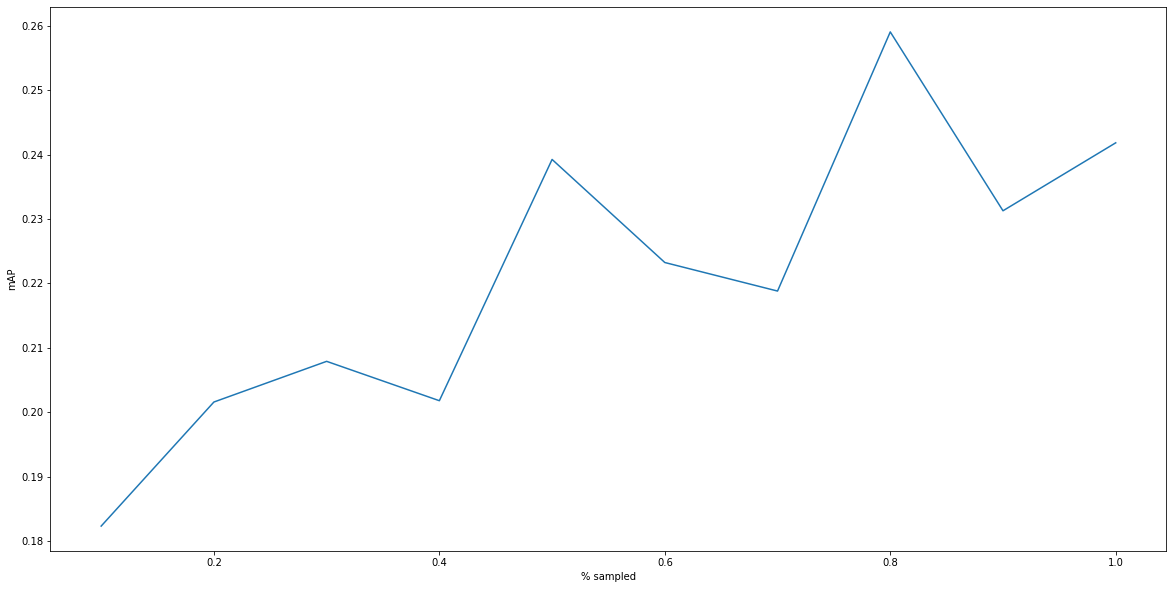

In [69]:
run = check_run()
results = test_random_acquisition(run)
mAP = save_run_results(run, results)
plot_mAP(mAP)


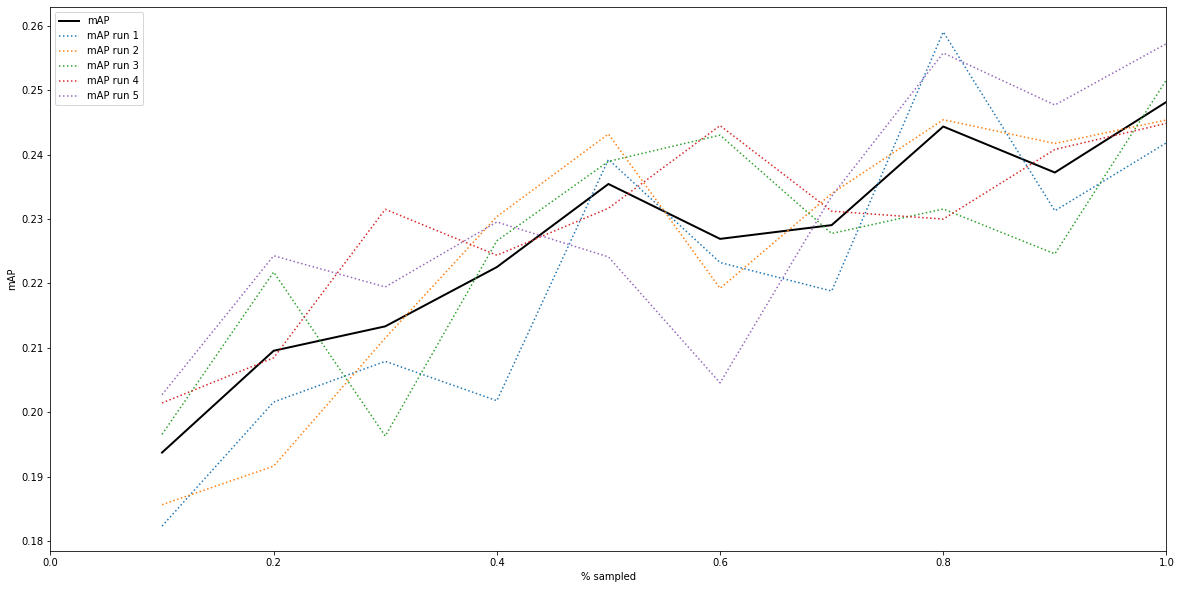

In [245]:
# Merge all data, average and plot
all_results = []

runs = check_run(verbose=False)
for run in range(runs):
    with open(f'mAP_rand_results_{run}.json', 'r') as infile:
        r = infile.read()
        results = json.loads(r)
        all_results.append(results)

all_results = np.unique(np.concatenate(tuple(all_results), axis=1), axis=1)
avg_results = np.vstack(
    (all_results[:, 0], np.mean(all_results[:, 1:], axis=1))).T


plot_mAP(avg_results, all_results)


### K Means Aquisition Function


In [7]:
def flatten_features(features, ids):
    flattened_features = []
    for id, feature in zip(ids, features):
        feature_vec = torch.flatten(feature).cpu().numpy()

        flattened_features.append([id, feature_vec])

    return np.array(flattened_features)


def format_features(features):
    return np.array([*features[:, 1]])

def save_json(object, filename):
    with open(filename, 'w') as outfile:
        outfile.write(object)

def load_json(filename):
    with open(filename) as infile:
                r = infile.read()
                data = json.loads(r)

    return data


class KmeansAcquisition(AcquisitionSampler):
    DATA_FILENAME = 'kmeans_data.json'

    def __init__(self, data_source, kmeans_sources=None, model=None, pcnt=0.2):
        super().__init__(pcnt)
        self.data_source = data_source
        
        if (kmeans_sources != None):
            if (type(kmeans_sources[0]) == np.ndarray) & (type(kmeans_sources[1]) == np.ndarray):
                print("using provided sources")
                self.feature_source = kmeans_sources[0]
                self.uncertainty_source = kmeans_sources[1]
        elif model != None:
            print("generating sources")
            self.feature_source, self.uncertainty_source, = self.get_features(model)
        else:
            raise "No feature source specified"

        self.create_centroids()

    def get_features(self, model):
        ids, _, _, _, _, features, mAPs = eval_model(
                    model, DataLoader(self.data_source, batch_size=BATCH_SIZE, collate_fn=fifty_collate_fn), True)
        
        features = format_features(flatten_features(features, ids))

        return features, mAPs

    def create_centroids(self):
        self.kmeans = faiss.Kmeans(self.feature_source.shape[1], 5, verbose=True)
        self.kmeans.train(self.feature_source)
        d, _ = self.kmeans.index.search(self.feature_source, 1)
        self.distances = d

    def sample(self):
        super().sample()
        
        # return samples
        indexes = list(range(len(self.data_source)))
        scores = np.array(self.uncertainty_source)[:,1].astype(np.float32)
        dists = self.distances.flatten()
        wgts = dists * scores

        probs = wgts / np.sum(wgts)

        return random.choices(indexes, probs, k=len(self))


    def __iter__(self):
        sampled = self.sample()

        return iter(sampled)

    def __len__(self):
        return math.floor(len(self.data_source) * self.pcnt)

In [8]:
data_path = os.path.join(CITYSCAPES_ROOT)

def load_dataset(dataset_name, data_path, label_path):
    # Either create the datset or load the existing dataset
    if fo.dataset_exists(dataset_name):
        dataset = fo.load_dataset(dataset_name)
    else:
        dataset = fo.Dataset.from_dir(
            name=dataset_name,
            data_path=data_path,
            labels_path=label_path,
            dataset_type=fo.types.COCODetectionDataset,
        )

    return dataset


train_label_path = os.path.join(
    CITYSCAPES_ROOT, "annotations", "instancesonly_filtered_gtFine_train.json")
scapes_train_coco = load_dataset(
    'cityscapes-train-COCO', data_path, train_label_path)

validation_label_path = os.path.join(
    CITYSCAPES_ROOT, "annotations", "instancesonly_filtered_gtFine_val.json")
scapes_validation_coco = load_dataset(
    'cityscapes-validation-COCO', data_path, validation_label_path)

class FiftyOneCityscapesCOCOTorchDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset):
        self.samples = fiftyone_dataset
        self.img_paths = self.samples.values("filepath")

    def __len__(self):
        return len(self.samples)

    def find_cat_by_label(self, label):
        if (label in COCO_LABELS):
            return next(item for item in COCO_cats if item["name"] == label)
        else:
            return None

    def __getitem__(self, idx):
        sample = self.samples[self.img_paths[idx]]

        image = Image.open(sample.filepath)
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = image / 255.0
        image = torch.FloatTensor(image)
        image = image.to(DEVICE)

        boxes = []
        labels = []
        areas= []
        iscrowd = []

        metadata = sample.metadata

        for detection in sample.ground_truth.detections:
            label = detection.label

            if label == 'rider':
                label = 'person'

            id = self.find_cat_by_label(label)['id']

            coco_obj = fouc.COCOObject.from_label(detection, metadata, category_id=id)

            xmin = coco_obj.bbox[0]
            ymin = coco_obj.bbox[1]
            xmax = xmin + coco_obj.bbox[2]
            ymax = ymin + coco_obj.bbox[3]

            boxes.append([xmin, ymin, xmax, ymax]) 
            labels.append(coco_obj.category_id)
            areas.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        boxes = torch.as_tensor(boxes, dtype=torch.float32).to(DEVICE)
        labels = torch.as_tensor(labels, dtype=torch.int64).to(DEVICE)
        areas = torch.as_tensor(areas, dtype=torch.float32).to(DEVICE)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64).to(DEVICE)

        target = {}
        target["image_id"] = sample.id
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = areas
        target["iscrowd"] = iscrowd

        return image, target


def fifty_collate_fn(batch):
    images, targets = zip(*batch)
    return images, targets


torch_scapes_train_coco = FiftyOneCityscapesCOCOTorchDataset(
    scapes_train_coco)

torch_scapes_validation_coco = FiftyOneCityscapesCOCOTorchDataset(
    scapes_validation_coco)

### Features gen

In [13]:
loader = DataLoader(torch_scapes_train_coco, batch_size=BATCH_SIZE, collate_fn=fifty_collate_fn,
                    sampler=KmeansAcquisition(torch_scapes_train_coco, model=model))

generating sources


  0%|          | 0/93 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
BATCH_SIZE=32

In [10]:
loader = DataLoader(torch_scapes_train_coco, batch_size=BATCH_SIZE, collate_fn=fifty_collate_fn,
                    sampler=KmeansAcquisition(torch_scapes_train_coco, kmeans_sources=(training_features, np.array(training_uncertainty))))

NameError: name 'training_features' is not defined

In [21]:
training_features = loader.sampler.feature_source
training_uncertainty = loader.sampler.uncertainty_source

In [178]:
with open('training_features.npy', 'wb') as f:
    np.save(f, training_features)

with open('training_uncertainty.npy', 'wb') as f:
    np.save(f, training_uncertainty)

In [9]:
with open('training_uncertainty.npy', 'rb') as f:
    test = np.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'training_uncertainty.npy'

### Kmeans Investigation

In [57]:
def show_tsne(x, labels, centroids, n_clusters=5):
    tsne_embeddings = TSNE(random_state=4).fit_transform(np.vstack([x, centroids]))
    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('TSNE plot')
    print(tsne_embeddings[-n_clusters:,:])
    ax.scatter(tsne_embeddings[:-n_clusters, 0], tsne_embeddings[:-n_clusters, 1], c=labels)
    ax.scatter(tsne_embeddings[-n_clusters:,0], tsne_embeddings[-n_clusters:,1],
        marker='o',
        s=200,
        c=range(n_clusters),
        linewidths=2,
        edgecolors="k"
    )
    ax.set_title(f"TSNE plot for n_clusters={n_clusters}")
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

WARNING clustering 2975 points to 101 centroids: please provide at least 3939 training points
WARNING clustering 2975 points to 201 centroids: please provide at least 7839 training points
WARNING clustering 2975 points to 301 centroids: please provide at least 11739 training points
WARNING clustering 2975 points to 401 centroids: please provide at least 15639 training points
WARNING clustering 2975 points to 501 centroids: please provide at least 19539 training points
WARNING clustering 2975 points to 601 centroids: please provide at least 23439 training points
WARNING clustering 2975 points to 701 centroids: please provide at least 27339 training points
WARNING clustering 2975 points to 801 centroids: please provide at least 31239 training points
WARNING clustering 2975 points to 901 centroids: please provide at least 35139 training points


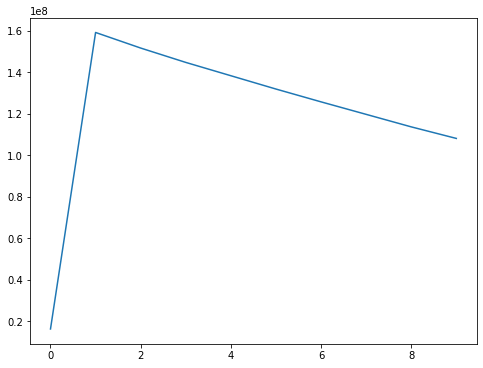

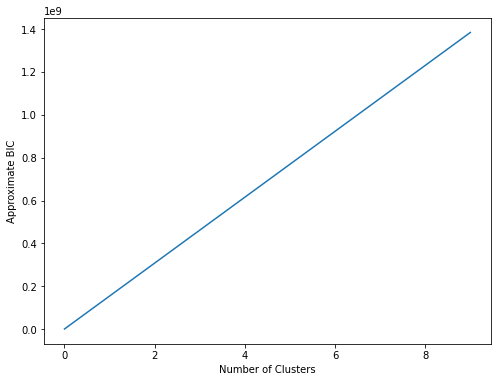

In [77]:
def compute_approximate_bic(kmeans, x):
    k = np.shape(kmeans.centroids)[0]*(np.shape(kmeans.centroids)[1] + 1)
    m = len(x)
    
    approx_bic = m*np.log(kmeans.obj[-1] / m) + k*np.log(m)
    return approx_bic    

def calculate_bic(max_cents, data):
    bic = []
    recon_error = []
    steps = 10
    vals = np.linspace(0, max_cents, steps + 1)[0:-1]
    with tqdm(total=len(vals)) as pbar:
        for i in vals:
            kmeans = faiss.Kmeans(data.shape[1], int(i + 1))
            kmeans.train(data)

            bic.append(compute_approximate_bic(kmeans, data))
            recon_error.append(kmeans.obj[-1])
            pbar.update(1)

    return bic, recon_error

bic, recon_error = calculate_bic(1000, training_features)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(recon_error)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');  

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 2.9189477   0.5384068 ]
 [ 0.02145016 -2.4816866 ]]


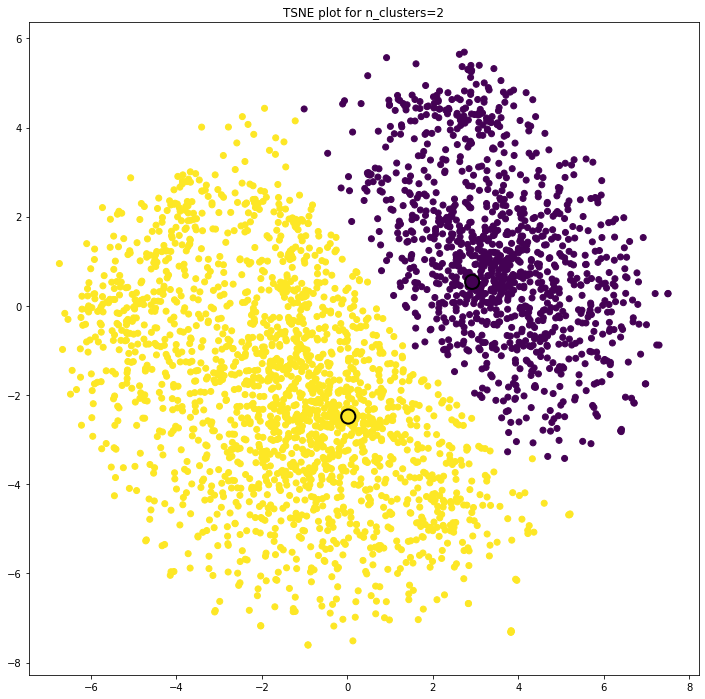

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-1.5583432   4.8718786 ]
 [-0.57345116 -3.5177658 ]
 [-0.34362262 -2.7120125 ]]


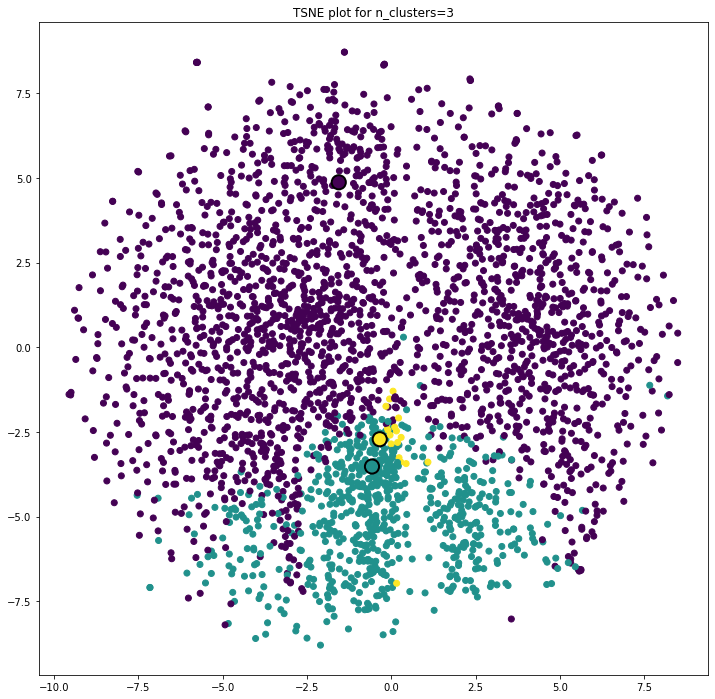

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-2.8729844   1.3386805 ]
 [ 0.8130183   1.46632   ]
 [ 0.33441436 -2.9998035 ]
 [ 1.8398771   3.8362    ]]


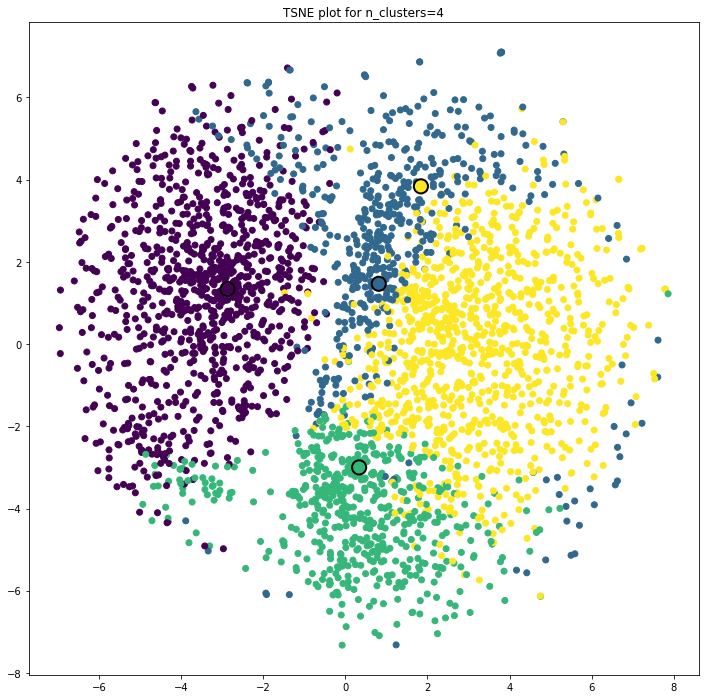

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 2.2094655  -3.1028152 ]
 [-1.180582   -0.12509537]
 [ 0.00903512 -0.81974435]
 [-2.1215749  -1.7310488 ]
 [-1.5320904  -2.259582  ]]


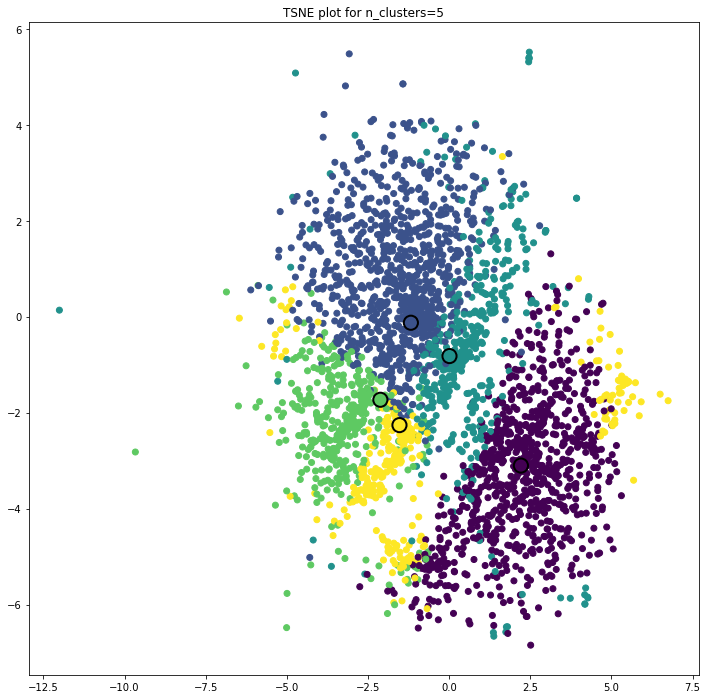

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[  9.906028  -37.194496 ]
 [-45.11779    -1.8421532]
 [ -7.184151   19.838524 ]
 [ 38.553555  -45.010765 ]
 [ 20.34786    14.533249 ]
 [ -1.700584    6.1819205]]


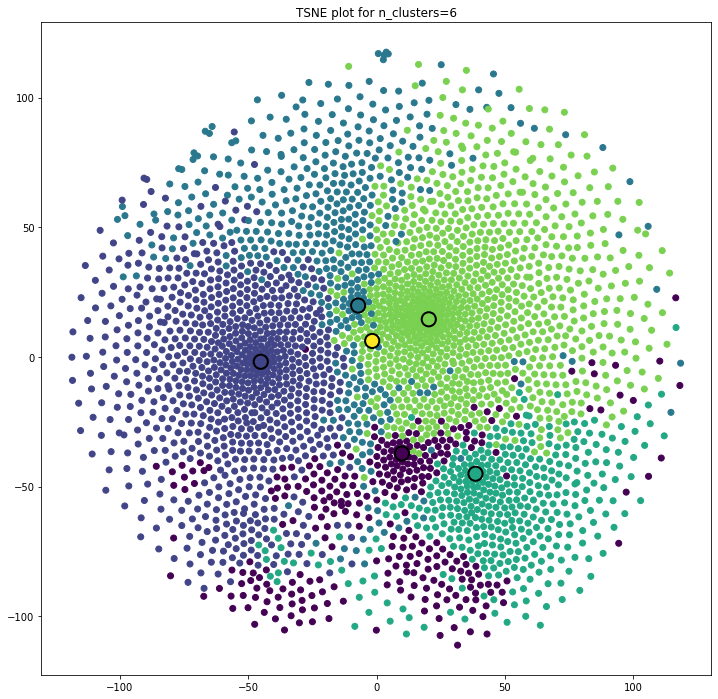

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 7.084086   -0.1483506 ]
 [ 1.2397296   2.1466205 ]
 [ 4.347365   -1.6971611 ]
 [ 5.5381193   1.0635636 ]
 [ 0.40182093 -2.5403066 ]
 [45.209213   -0.6786593 ]
 [ 1.1396685  -1.8140068 ]]


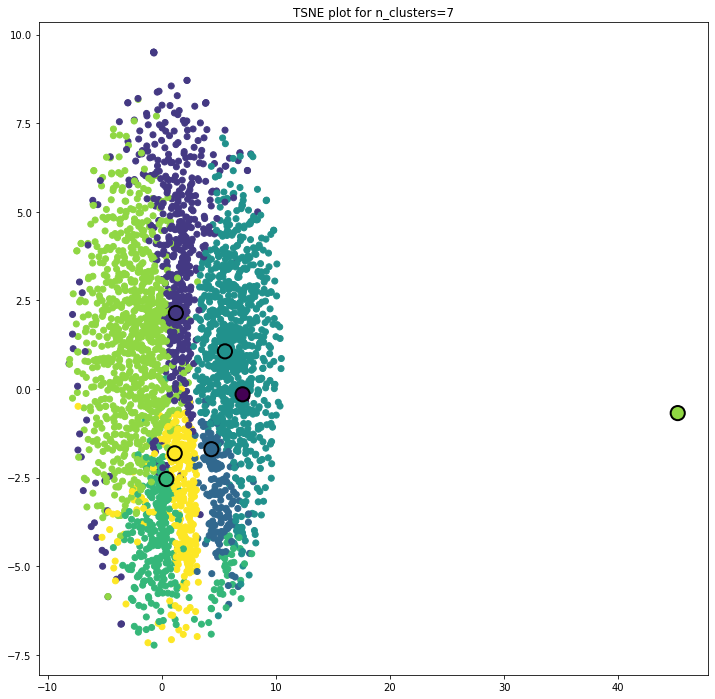

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 5.3711187e+03 -6.0395146e+03]
 [-3.2193916e+01 -1.5700817e+01]
 [ 2.6991917e+01  3.1914845e+01]
 [ 3.4331045e+00  6.3286789e+01]
 [-1.3632059e+01 -3.7057678e+01]
 [-3.6951427e+01 -1.5669184e+00]
 [ 2.1034975e+01 -2.6183014e+00]
 [ 1.6803728e+01  2.1359259e+01]]


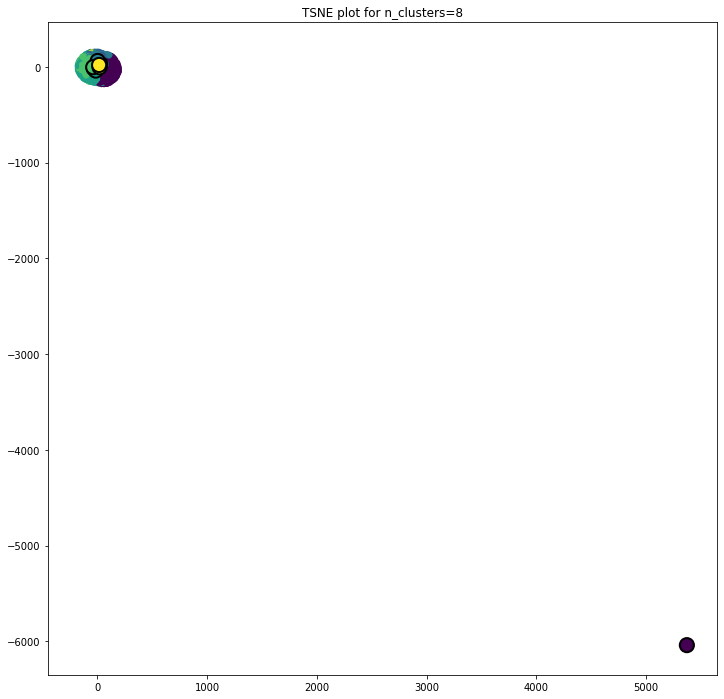

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 3.3063147  -2.0642416 ]
 [ 0.51802266 -4.0196285 ]
 [ 1.0574834  -0.8984823 ]
 [ 0.8743407  -2.1283147 ]
 [ 1.2072035  -2.8481529 ]
 [ 2.8728242  -2.929387  ]
 [ 1.9791101   0.37907028]
 [ 2.4667525  -3.0011685 ]
 [ 2.330932   -3.0555892 ]]


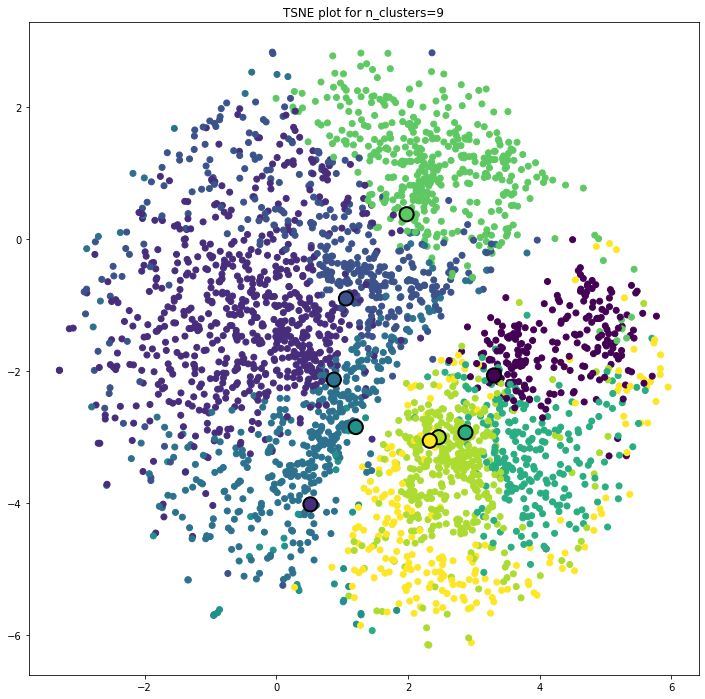

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-14.694202   -1.9488959]
 [-11.434247   -5.774091 ]
 [-26.817198   14.543962 ]
 [-13.443297    5.092233 ]
 [ 11.047309   -3.557623 ]
 [-11.971251    8.296215 ]
 [ 10.902481   14.716455 ]
 [  9.827058   -4.8985014]
 [  3.8483744  -6.550367 ]
 [  3.2778237  10.593271 ]]


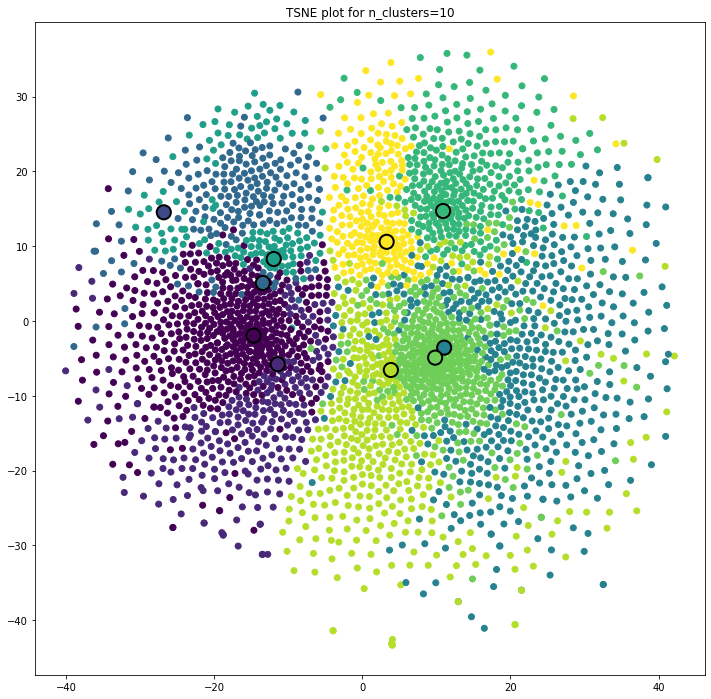

In [86]:
for num_clusters in range(2, 11):
  kTest = faiss.Kmeans(training_features.shape[1], num_clusters)
  kTest.train(training_features)
  kTest.centroids

  d, labels = kTest.index.search(training_features, 1)
  kTest.centroids
  show_tsne(training_features, labels, kTest.centroids, num_clusters)


/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[ 2.2094655  -3.1028152 ]
 [-1.180582   -0.12509537]
 [ 0.00903512 -0.81974435]
 [-2.1215749  -1.7310488 ]
 [-1.5320904  -2.259582  ]]


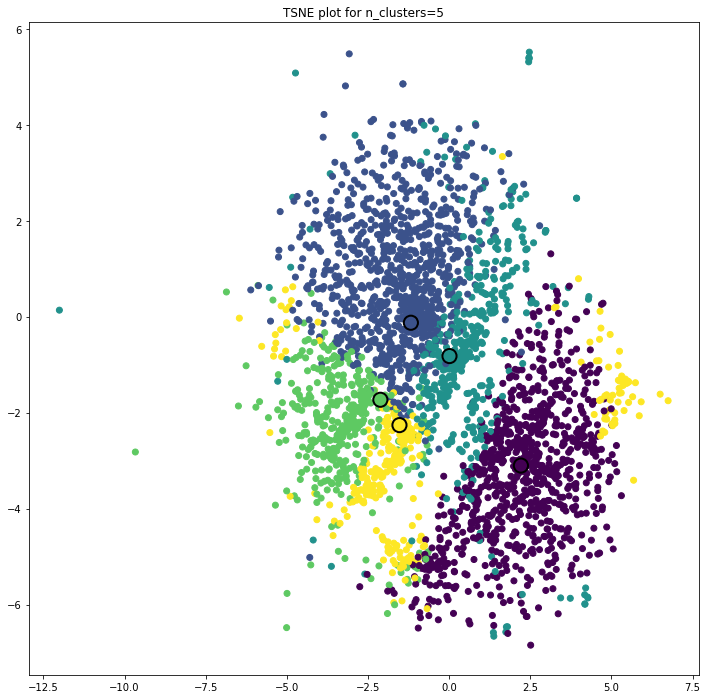

In [168]:
NUM_CLUSTERS=5
kmeans_5 = faiss.Kmeans(training_features.shape[1], NUM_CLUSTERS)
kmeans_5.train(training_features)

d, kmeans_5_labels = kmeans_5.index.search(training_features, 1)
show_tsne(training_features, kmeans_5_labels, kmeans_5.centroids, NUM_CLUSTERS)


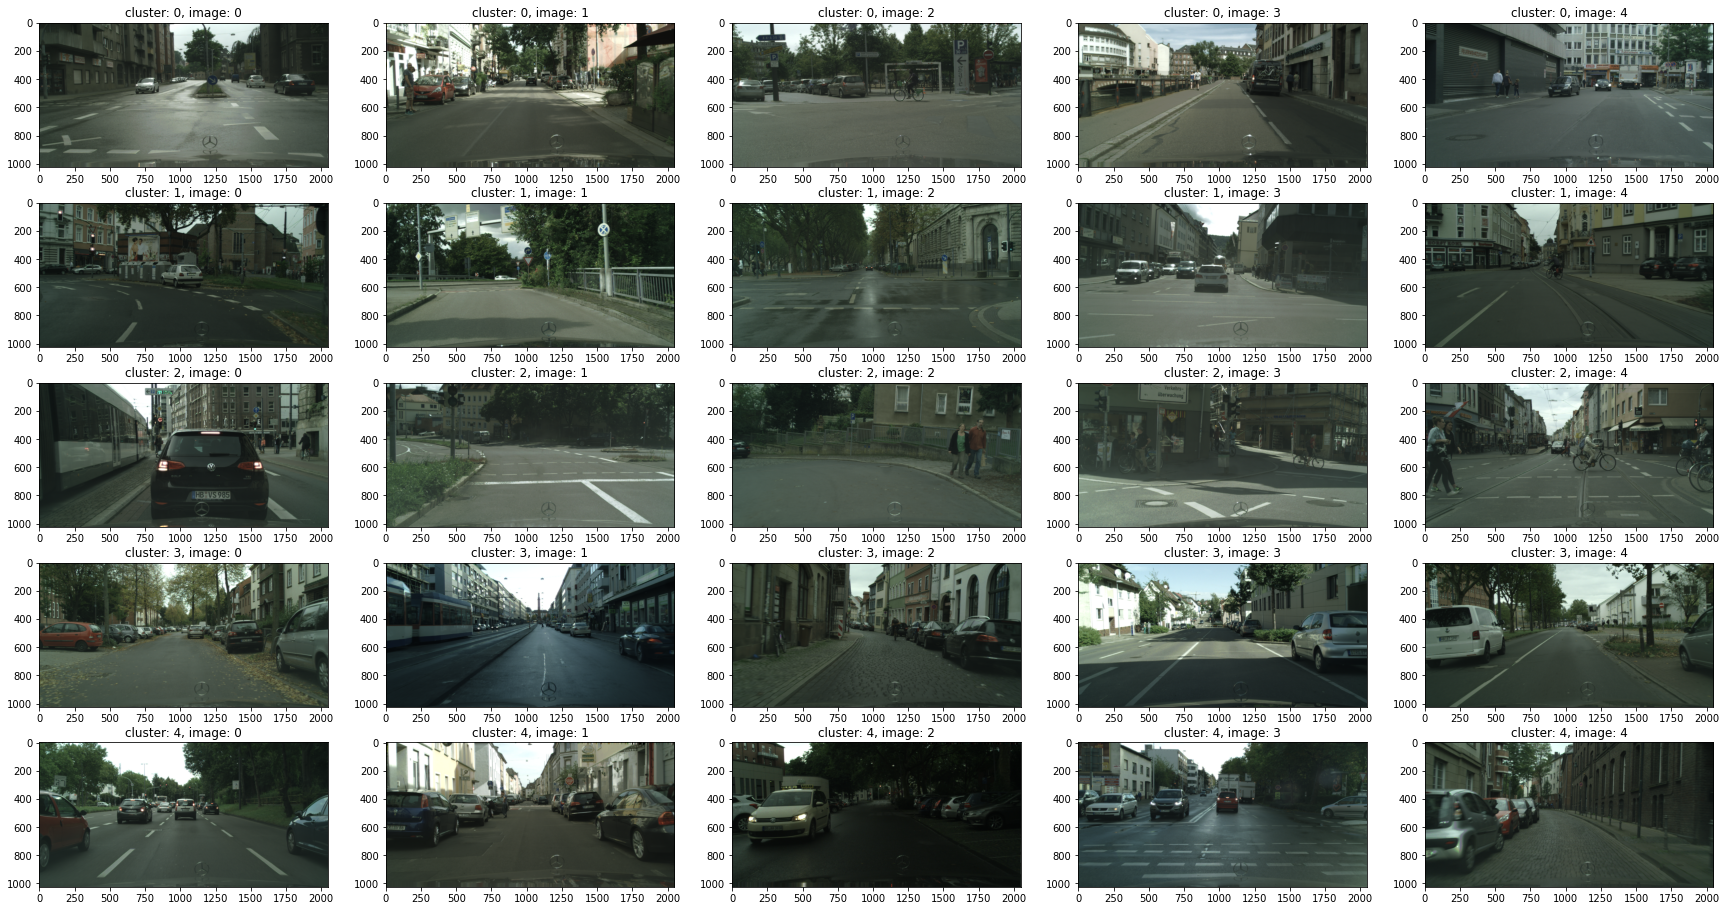

In [174]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(30, 16))

cluster_image_idxs = []
for cluster in np.unique(kmeans_5_labels):
  image_idxs = []
  for n in range(5):
    cluster_idxs = np.where(kmeans_5_labels==cluster)[0]
    image_idx = random.choice(cluster_idxs)

    image_idxs.append(image_idx)

    img = torch_scapes_train_coco[image_idx][0]
    ax[cluster][n].imshow(img.numpy().transpose((1,2,0)))
    ax[cluster][n].set_title(f'cluster: {cluster}, image: {n}')

  cluster_image_idxs.append(image_idxs)

cluster_image_idxs = np.array(cluster_image_idxs)

In [164]:
kmeans_5_embed = TSNE(random_state=4).fit_transform(np.vstack([training_features, kmeans_5.centroids]))

/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brendanrussell/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


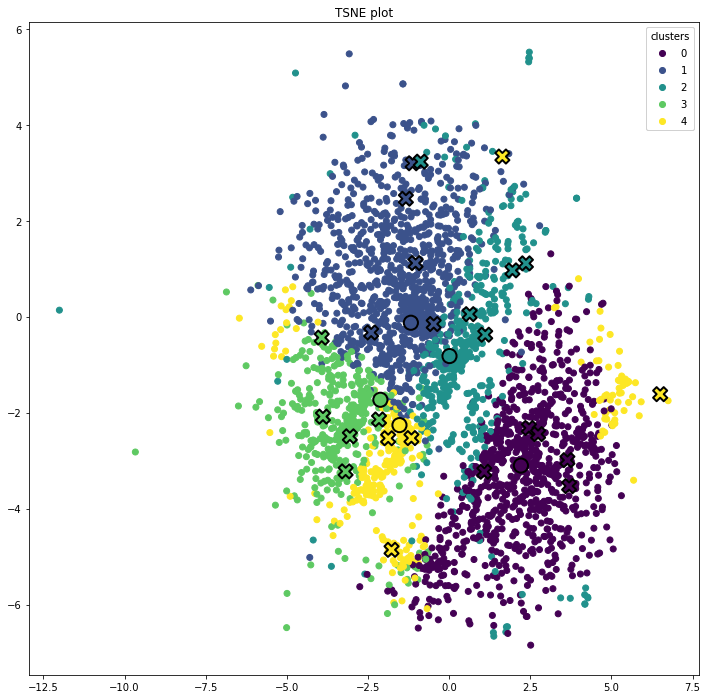

In [176]:
key_idxs = cluster_image_idxs.flatten()

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.set_title('TSNE plot')
cent_embed = kmeans_5_embed[-5:,:]
img_embed = kmeans_5_embed[:-5,:]

img_scatter = ax.scatter(img_embed[:,0], img_embed[:,1], c=kmeans_5_labels)

legend = ax.legend(*img_scatter.legend_elements(), title="clusters")
ax.add_artist(legend)

ax.scatter(cent_embed[:,0], cent_embed[:,1],
    marker='o',
    s=200,
    c=np.unique(kmeans_5_labels),
    linewidths=2,
    edgecolors="k"
)

ax.scatter(img_embed[key_idxs,0], img_embed[key_idxs,1],
    marker='X',
    s=200,
    c=kmeans_5_labels[key_idxs],
    linewidths=2,
    edgecolors="k",
)

plt.show()

In [17]:
MODEL_ROOT = './models'

val_dataloader = DataLoader(torch_scapes_validation_coco, batch_size=BATCH_SIZE, shuffle=True, collate_fn=fifty_collate_fn)

def check_run(acquisition='kmeans', verbose = False):
    inc = 0.1
    pcnts = np.around(np.arange(0, 1 + inc, inc), 1)

    run = 0
    checking = True

    while checking:
        run_incomplete = False
        
        if  os.path.exists(f'mAP_{acquisition}_results_{run}.json'):
            if verbose:
                print(f'run {run} results exist')

            with open(f'mAP_{acquisition}_results_{run}.json', 'r') as infile:
                r = infile.read()
                results = np.array(json.loads(r))
            
            if ~np.array_equal(results, pcnts):
                if verbose:
                    print(f'run {run} results incomplete')
                checking = False
                break

            run += 1
            continue
        
        for pcnt in pcnts:
            model_name = os.path.join(MODEL_ROOT, f'model_v2.0_{acquisition}_{pcnt}_{run}')
            if os.path.exists(model_name):
                if verbose:
                    print(f'{model_name} exists')
            else:
                run_incomplete = True
                break

        if run_incomplete:
            if pcnt == pcnts[0]:
                if verbose:
                    print(f'run {run} not started')
            else:
                if verbose:
                    print(f'run {run} partially completed')
            checking = False
        else:
            if verbose:
                print(f'run {run} already completed')
            run += 1

    return run

def test_acquisition(run, acquisition='kmeans'):
    print(f'Starting run {run}, {acquisition}')
    inc = 0.1
    pcnts = np.around(np.arange(0, 1 + inc, inc), 1)

    results = []
    for pcnt in pcnts:
        print(f'Testing {pcnt}')
        model_name = os.path.join(MODEL_ROOT, f'model_v2.0_{acquisition}_{pcnt}_{run}')
        if os.path.exists(model_name):
            print(f'Model already trained for {pcnt}, loading existing')
            model = torch.load(model_name)
        else:
            print(f'Training model for {pcnt}')
            if acquisition == 'kmeans':
                loader = DataLoader(torch_scapes_train_coco, batch_size=BATCH_SIZE, collate_fn=fifty_collate_fn,
                        sampler=KmeansAcquisition(torch_scapes_train_coco, kmeans_sources=(training_features, np.array(training_uncertainty)), pcnt=pcnt))
            elif acquisition == 'rand':
                loader = DataLoader(torch_scapes_train_coco, batch_size=BATCH_SIZE, collate_fn=fifty_collate_fn,
                        sampler=RandomAcquisition(torch_scapes_train_coco, pcnt=pcnt))
            else:
                raise 'no valid acquistion loader'
            # Use pretrained model frcnn-mobilenet
            model = detection.fasterrcnn_mobilenet_v3_large_320_fpn(
                pretrained=True,
                progress=True,
                num_classes=len(COCO_LABELS),
                pretrained_backbone=True
            ).to(DEVICE)

            model = train_model(model, loader)
            torch.save(model, model_name)

        print(f'Evaluating model for {pcnt}')
        evaluation = eval_model(model, val_dataloader)

        results.append([pcnt, evaluation])

    print(f'Completed run {run}')
    return results

def save_run_results(run, results, acquisition='kmeans'):
    print(f'Saving {acquisition} run {run} results')
    mAP = np.array([[result[0], result[1][2]['mAP']] for result in results])
    json_list = json.dumps(mAP.tolist())

    filename = f'mAP_{acquisition}_results_{run}.json'

    if os.path.exists(filename):
        print("results for runs already exist")
    else:
        with open(filename, 'w') as outfile:
            outfile.write(json_list)

    return mAP


def plot_mAP(mAP, all_mAP=[]):
    plt.xlim((0, 1))
    plt.plot(mAP[:, 0], mAP[:, 1], 'k', linewidth=2, label='mAP')

    if np.any(all_mAP):
        print(all_mAP.shape)
        for i in range(1, all_mAP.shape[1]):
            plt.plot(all_mAP[:, 0], all_mAP[:, i], ':', label=f'mAP run {i}')
            plt.legend()

    plt.xlabel('% sampled')
    plt.ylabel("mAP")
    plt.show()

def plot_all_mAP(acquisition='kmeans'):
    # Merge all data, average and plot
    all_results = []

    runs = check_run(acquisition)
    print(runs)
    for run in range(runs):
        print(run)
        with open(f'mAP_{acquisition}_results_{run}.json', 'r') as infile:
            r = infile.read()
            results = json.loads(r)
            all_results.append(results)

    all_results = np.unique(np.concatenate(tuple(all_results), axis=1), axis=1)
    print(all_results)

    avg_results = np.vstack(
        (all_results[:, 0], np.mean(all_results[:, 1:], axis=1))).T


    plot_mAP(avg_results, all_results)



In [18]:
run = check_run()
results = test_acquisition(run)
mAP = save_run_results(run, results)
plot_mAP(mAP)

Starting run 0, kmeans
Testing 0.0
Model already trained for 0.0, loading existing
Evaluating model for 0.0


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
run = check_run(acquisition='rand')
results = test_acquisition(run, acquisition='rand')
mAP = save_run_results(run, results, acquisition='rand')
plot_all_mAP(acquisition='rand')

Starting run 0, rand
Testing 0.0
Training model for 0.0


0it [00:00, ?it/s]

Sampling data with RandomAcquisition
Evaluating model for 0.0


  0%|          | 0/16 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 8.00 GiB total capacity; 6.25 GiB already allocated; 0 bytes free; 6.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

5
0
1
2
3
4
[[0.         0.18695157 0.18695157 0.18695157 0.18695172 0.18695174]
 [0.1        0.22494937 0.1626618  0.20417606 0.20284391 0.20487112]
 [0.2        0.20878511 0.21045531 0.21968368 0.21320334 0.21556549]
 [0.3        0.23668546 0.22156582 0.20912395 0.21483543 0.20839639]
 [0.4        0.24391339 0.21966942 0.2645434  0.22642091 0.22328921]
 [0.5        0.24614405 0.22172259 0.21180231 0.23562006 0.22212956]
 [0.6        0.21291346 0.23973977 0.24306831 0.21327396 0.22341243]
 [0.7        0.24598395 0.22356916 0.24864769 0.22478864 0.22779051]
 [0.8        0.22326286 0.21974729 0.24948292 0.22778769 0.2380196 ]
 [0.9        0.25690702 0.24210202 0.2446421  0.24498456 0.24330774]
 [1.         0.23890508 0.23487901 0.23864248 0.23507763 0.23841478]]
(11, 6)


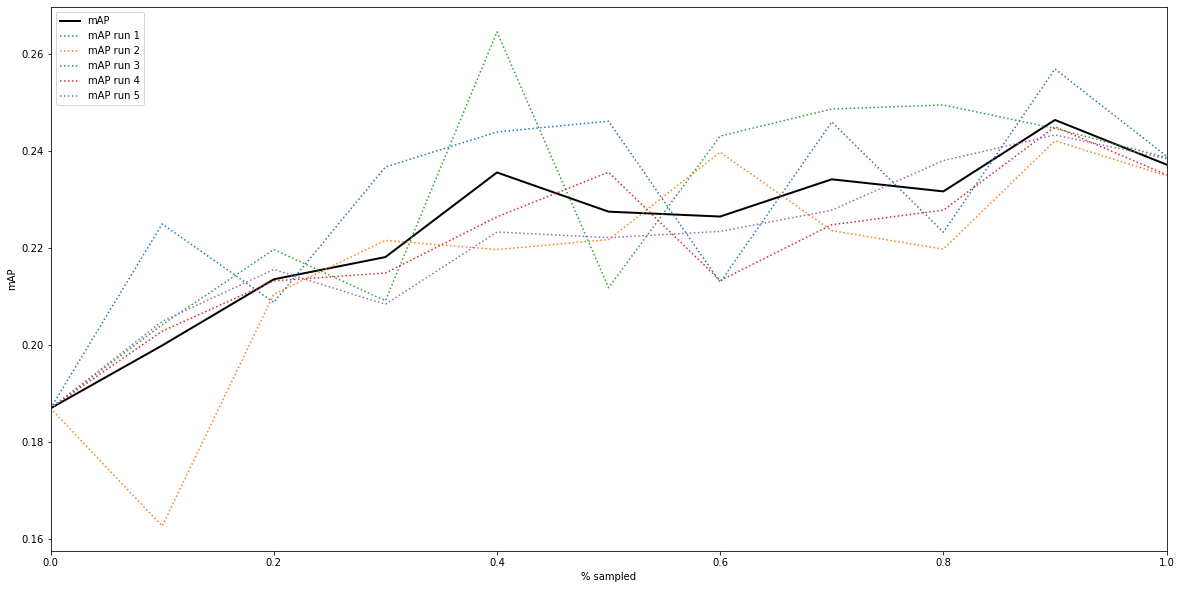

In [63]:
plot_all_mAP()

Saving kmeans run 2 results


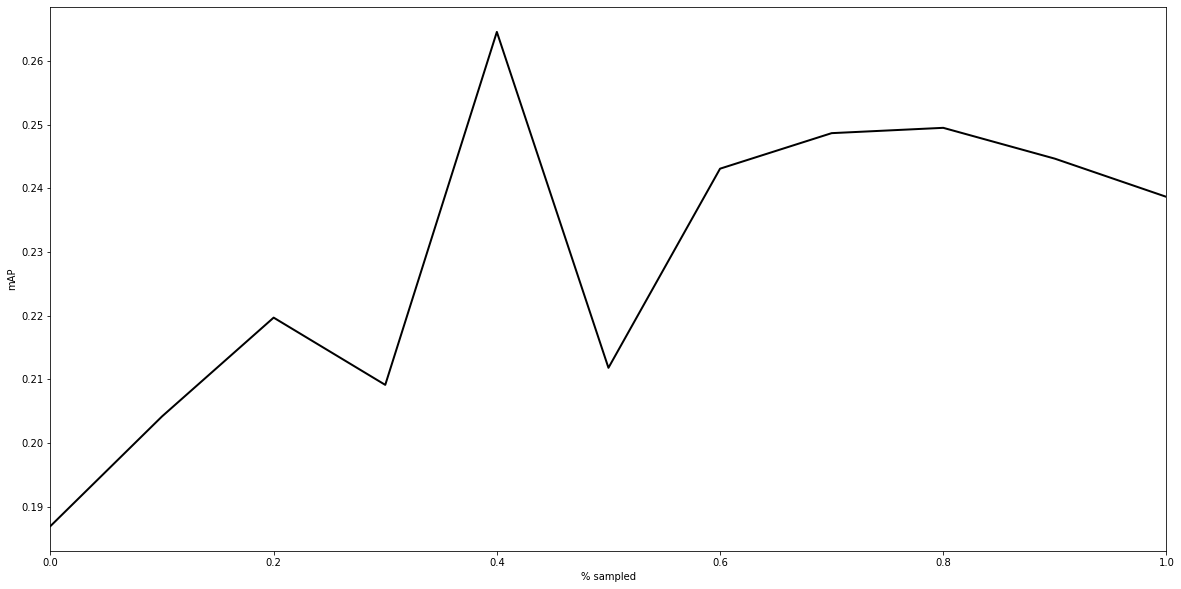

In [249]:
mAP = save_run_results(run, results)
plot_mAP(mAP)

5